In [2]:
import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
import sklearn.metrics
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt

import dimod
from qiskit.quantum_info import Pauli
from qiskit_aqua import Operator
from qiskit_aqua import get_aer_backend, QuantumInstance
from qiskit_aqua.algorithms import QAOA
from qiskit_aqua.components.optimizers import COBYLA

Any learning algorithm will always have strengths and weaknesses: a single model is unlikely to fit every possible scenario. Ensembles combine multiple models to achieve higher generalization performance than any of the constituent models is capable of. How do we assemble the weak learners? We can use some sequential heuristics. For instance, given the current collection of models, we can add one more based on where that particular model performs well. Alternatively, we can look at all the correlations of the predictions between all models, and optimize for the most uncorrelated predictors. Since this latter is a global approach, it naturally maps to a quantum computer. But first, let's take a look a closer look at loss functions and regularization, two key concepts in machine learning.

# 1) Loss Functions and Regularization

If you can solve a problem by a classical computer -- let that be a laptop or a massive GPU cluster -- there is little value in solving it by a quantum computer that costs ten million dollars. The interesting question in quantum machine learning is whether there are problems in machine learning and AI that fit quantum computers naturally, but are challenging on classical hardware. This, however, requires a good understanding of both machine learning and contemporary quantum computers.

In this course, we primarily focus on the second aspect, since there is no shortage of educational material on classical machine learning. However, it is worth spending a few minutes on going through some basics.

Let us take a look at the easiest possible problem: the data points split into two, easily distinguishable sets. We randomly generate this data set:

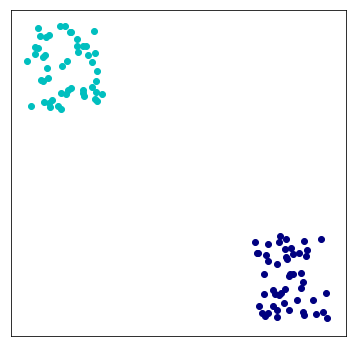

In [3]:
c1 = np.random.rand(50, 2) / 5
c2 = (-0.6, 0.5) + np.random.rand(50, 2) / 5

data = np.concatenate((c1, c2))
labels = np.array([0] * 50 + [1] *50)
plt.figure(figsize=(6, 6))
plt.subplot(111, xticks=[], yticks=[])
plt.scatter(data[:50, 0], data[:50, 1], color='navy')
plt.scatter(data[50:, 0], data[50:, 1], color='c');

## Train / Test split

Let's shuffle the data set into a training set that we are going to optimize over (2/3 of the data), and a test set where we estimate our generalization performance. 

In [4]:
idx = np.arange(len(labels))
np.random.shuffle(idx)

# train on a random 2/3 and test on the remaining 1/3

idx_train, idx_test = idx[:2 * len(idx) // 3], idx[2 * len(idx) // 3:]

X_train, X_test = data[idx_train], data[idx_test]
y_train, y_test = labels[idx_train], labels[idx_test]

We will use the package `scikit-learn` to train various machine learning models.

In [5]:
metric = sklearn.metrics.accuracy_score

## Perceptron

Let's train a perceptron (basically similar to logistic regression but where the activation function is a simple unit step).  This is a **linear model** whose loss function is defined by $\frac{1}{N}\sum_{i=1}^N |h(x_i)-y_i)|$.

In [6]:
model_1 = Perceptron(max_iter=1000, tol=1e-3)
model_1.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_1.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_1.predict(X_test))))

accuracy (train):  1.00
accuracy (test):  1.00


It does a great job. It is a linear model, meaning its decision surface is a plane. 

## Support Vector Classification

Our dataset is separable by a plane, so let's try another linear model, but this time a support vector machine. If you eyeball our dataset, you will see that to define the separation between the two classes, actually only a few points close to the margin are relevant. These are called support vectors and support vector machines aim to find them. Its objective function measures the loss and it has a regularization term with a weight $C$. The $C$ hyperparameter controls a regularization term that penalizes the objective for the number of support vectors:

In [7]:
model_2 = SVC(kernel='linear', C=1)
model_2.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_2.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_2.predict(X_test))))
print('Number of support vectors:', sum(model_2.n_support_))

accuracy (train):  1.00
accuracy (test):  1.00
Number of support vectors: 12


In [8]:
model_2 = SVC(kernel='linear', C=0.01)
model_2.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_2.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_2.predict(X_test))))
print('Number of support vectors:', sum(model_2.n_support_))

accuracy (train):  0.52
accuracy (test):  0.47
Number of support vectors: 64


You can see that the model gets confused by using two many datapoints in the final classifier. This is one example where regularization helps.

# 2) Ensemble methods

Ensembles yield better results when there is considerable diversity among the base classifiers. If diversity is sufficient, base classifiers make different errors, and a strategic combination may reduce the total error, ideally improving generalization performance. A constituent model in an ensemble is also called a base classifier or weak learner, and the composite model a strong learner.

The generic procedure of ensemble methods has two steps. First, develop a set of base classifiers from the training data. Second, combine them to form the ensemble. In the simplest combination, the base learners vote, and the label prediction is based on majority. More involved methods weigh the votes of the base learners. 

**We define our figure of merit as accuracy in a balanced dataset**.

In [9]:
metric = sklearn.metrics.accuracy_score

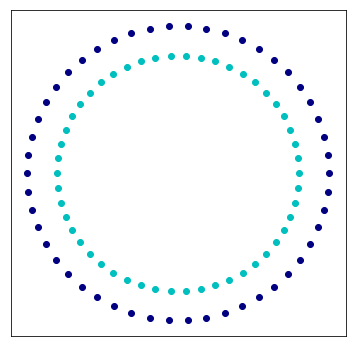

In [10]:
np.random.seed(0)

data, labels = sklearn.datasets.make_circles()
idx = np.arange(len(labels))
np.random.shuffle(idx)

# train on a random 2/3 and test on the remaining 1/3

idx_train, idx_test = idx[: 2 * len(idx) // 3], idx[2 * len(idx) // 3:]

X_train, X_test = data[idx_train], data[idx_test]

# binary -> spin
y_train, y_test = 2 * labels[idx_train] - 1, 2 * labels[idx_test] - 1

scaler, normalizer = sklearn.preprocessing.StandardScaler(), sklearn.preprocessing.Normalizer()

X_train = scaler.fit_transform(X_train)
X_train = normalizer.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)
X_test = normalizer.fit_transform(X_test)

plt.figure(figsize=(6, 6))
plt.subplot(111, xticks=[], yticks=[])
plt.scatter(data[labels == 0, 0], data[labels == 0, 1], color='navy')
plt.scatter(data[labels == 1, 0], data[labels == 1, 1], color='c');

## Perceptron

Let's train a perceptron:

In [11]:
model_1 = Perceptron(max_iter=1000, tol=1e-3)
model_1.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_1.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_1.predict(X_test))))

accuracy (train):  0.58
accuracy (test):  0.38


Since its decision surface is linear, we get a poor accuracy. Would a support vector machine with a nonlinear kernel fare better?

## Support Vector Machine

Radial basis function kernel.

**!!!changing [gamma parameter](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from auto to scale seems to have a VERY strong influence on further results!!!**

In [12]:
model_2 = SVC(kernel='rbf', gamma='auto')
model_2.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_2.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_2.predict(X_test))))

accuracy (train):  0.64
accuracy (test):  0.24


It performs better on the training set, but at the cost of extremely poor generalization. 

## AdaBoost

Boosting is an ensemble method that explicitly seeks models that complement one another. The variation between boosting algorithms is how they combine weak learners. Adaptive boosting (AdaBoost) is a popular method that combines the weak learners in a sequential manner based on their individual accuracies. It has a convex objective function that does not penalize for complexity: it is likely to include all available weak learners in the final ensemble. Let's train AdaBoost with a few weak learners:

In [13]:
model_3 = AdaBoostClassifier(n_estimators=3)
model_3.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_3.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_3.predict(X_test))))

accuracy (train):  0.65
accuracy (test):  0.29


Its performance is marginally better than that of the SVM.

# 3) QBoost

The idea of Qboost is that optimization on a quantum computer is not constrained to convex objective functions, therefore we can add arbitrary penalty terms and rephrase our objective [[1](#1)]. Qboost solves the following problem:

$$
\mathrm{argmin}_{w} \left(\frac{1}{N}\sum_{i=1}^{N}\left(\sum_{k=1}^{K}w_kh_k(x_i)-
y_i\right)^2+\lambda\|w\|_0\right),
$$

where $h_k(x_i)$ is the prediction of (weak) classifier learner indexed by $k$ applied to the training instance $i$ and $y_i$ is the corresponding ground-truth label.  In other words, for each training instance $i \in [1, \cdots, N]$, we are summing up all the L2 losses defined by the ensemble of classifiers $k \in [1, \cdots, K]$.   **The weights $w_k$ are binary so this objective function maps to an Ising model**. The regularization in the $l_0$ norm ensures sparsity.

Let us expand the quadratic part of the objective:

$$
\mathrm{argmin}_{w} \left(\frac{1}{N}\sum_{i=1}^{N}
\left( \left(\sum_{k=1}^{K} w_k h_k(x_i)\right)^{2} -
2\sum_{k=1}^{K} w_k h_k(x_i)y_i + y_i^{2}\right) + \lambda \|w\|_{0}
\right).
$$

Because we are considering a binary classifier, $y_i^{2}$ is a constant offset that does not change the nature of the optimization problem which can be reduced to:

$$
\mathrm{argmin}_{w} \left(
\frac{1}{N}\sum_{k=1}^{K}\sum_{l=1}^{K} w_k w_l
\left(\sum_{i=1}^{N}h_k(x_i)h_l(x_i)\right) - 
\frac{2}{N}\sum_{k=1}^{K}w_k\sum_{i=1}^{N} h_k(x_i)y_i +
\lambda \|w\|_{0} \right).
$$

This form shows that we consider all correlations between the predictions of the weak learners: there is a summation of $h_k(x_i)h_l(x_i)$. Since this term has a positive sign, **we penalize for correlations**. On the other hand, the correlation with the true label, $h_k(x_i)y_i$, has a negative sign. The regularization term remains unchanged.

Let us consider all three models from the previous section as weak learners:
- model_1 / perceptron
- model_2 / support vector machine (RBF kernel)
- model_3 / AdaBoost

In [14]:
models = [model_1, model_2, model_3]

n_models = len(models)

The predictions are scaled to be in the set $\{-1/\text{n_models}, 1/\text{n_models}\}$ to reflect the averaging in the objective (**see reference paper for details**).

In [15]:
predictions = np.array([h.predict(X_train) for h in models], dtype=np.float64)

predictions *= 1/n_models

As a sanity check, we can verify the training errors reported earlier:

In [16]:
modAcc = lambda pred: sum([np.sign(x) == np.sign(y) for x, y in zip(pred, y_train)]) / len(y_train)
mod1Acc = modAcc(predictions[0])
mod2Acc = modAcc(predictions[1])
mod3Acc = modAcc(predictions[2])
print('model_1 = %.2f\nmodel_2 = %.2f\nmodel_3 = %.2f' % (mod1Acc, mod2Acc, mod3Acc))

model_1 = 0.58
model_2 = 0.64
model_3 = 0.65


## A) Solving by simulated annealing

First, let us start by setting $\lambda = 1$:

In [17]:
λ = 1

We create the quadratic binary optimization of the objective function as we expanded above.  First of all, the off-diagonal coupling terms $w_k w_l$ are given by:

In [18]:
w = np.dot(predictions, predictions.T)

Next we need to correct the diagonal terms (i.e. those that contain only a single $w_k$) corresponding to the linear part of the optimization problem.  Note that the first term also has a linear contribution when $k=l$.  This is because of the binary property of the weights and the classes such that:

$$
\begin{align*}
w_k w_k &= w_k \\
h_k(x_i) h_k(x_i) &= 1
\end{align*}
$$

Those diagonal components are given by:

In [19]:
wii = len(X_train) / (n_models ** 2) + λ - 2 * np.dot(predictions, y_train)

from which we can fill all the components of $w$:

In [20]:
w[np.diag_indices_from(w)] = wii

Finally, we encode the coupling terms as:

In [21]:
W = {(i, j): w[i, j] for i in range(n_models) for j in range(i, n_models)}
W

{(0, 0): 1.666666666666667,
 (0, 1): 2.4444444444444446,
 (0, 2): 2.2222222222222223,
 (1, 1): -3.666666666666666,
 (1, 2): 4.444444444444444,
 (2, 2): -5.0}

We are now in a position to solve the quadratic binary optimization with simulated annealing and read out the optimal weights:

In [22]:
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample_qubo(W, num_reads=10)
weights = list(response.first.sample.values())

In [23]:
weights

[0, 0, 1]

Only AdaBoost made it to the final ensemble. The first two models perform poorly and their predictions are correlated.

If you remove regularization by setting $\lambda=0$ above, the second model also enters the ensemble, decreasing overall performance. This shows that the regularization is in fact important.

## B) Solving by QAOA (Quantum Approximate Optimization Algorithm)

**Since our problem is just an Ising model, we can also solve it on a gate-model quantum computer by QAOA**. Let us explicitly map the binary optimization to the Ising model using the ``qubo_to_ising`` [method](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/generated/dimod.utilities.qubo_to_ising.html) provided by D-Wave:

In [24]:
h, J, offset = dimod.qubo_to_ising(W)

print('h = %s' % h)
print('J = %s' % J)
print('constant offset applied to energy = %.2f' % offset)

h = {0: 2.0, 1: -0.11111111111111094, 2: -0.8333333333333335}
J = {(0, 1): 0.6111111111111112, (0, 2): 0.5555555555555556, (1, 2): 1.111111111111111}
constant offset applied to energy = -1.22


We have to translate the Ising couplings to be suitable for solving by the QAOA routine:

In [25]:
num_nodes = w.shape[0]

Xvector = np.zeros(num_nodes)

def logicVec(vecSize, *indices):
    initVec = np.zeros(vecSize)
    for index in indices:
        assert index < vecSize
        initVec[index] = 1
    return initVec

diagonal = [[h[i], Pauli(logicVec(num_nodes, i), Xvector)] for i in h]
offDiagonal = [[J[i, j], Pauli(logicVec(num_nodes, i, j), Xvector)] for i, j in J]

# note that the ORDER in the list is important

# ising_model = Operator(paulis = diagonal + offDiagonal)
ising_model = Operator([diagonal[0], offDiagonal[0], offDiagonal[1], diagonal[1], offDiagonal[2], diagonal[2]])

Next we run the optimization using the QAOA implementation provided by D-Wave (instead of our own as done in the previous notebook).

In [27]:
qaoa = QAOA(ising_model, optimizer = COBYLA(), p=1, operator_mode='matrix')
quantum_instance = QuantumInstance(get_aer_backend('statevector_simulator'), shots=100)
result = qaoa.run(quantum_instance)

Finally, we extract the most likely solution; **I'm hoping, as Peter does, that this is self-explanatory :-) ...**

In [28]:
k = np.argmax(result['eigvecs'][0])
weights = np.zeros(num_nodes)
for i in range(num_nodes):
    weights[i] = k % 2
    k >>= 1

Finally, we obtain the following set of weights to assign to all the models:

In [29]:
weights

array([1., 0., 1.])

Now, we can apply this model ensemble to the datasets and measure the accuracy

In [30]:
def modelPrediction(modelID, dataSet):
    modelPrediction = weights[modelID] * models[modelID].predict(dataSet)
    avgPrediction = np.sum(modelPrediction) / len(dataSet)
    return {'modelPrediction': modelPrediction, 'avgPrediction': avgPrediction}

def ensembleRes(dataSet):
    ensemblePreds = [modelPrediction(modelID, dataSet) for modelID in range(n_models)]
    avgPred = sum([pred['avgPrediction'] for pred in ensemblePreds]) / n_models
    accumulatePred = sum([pred['modelPrediction'] for pred in ensemblePreds])
    return np.sign(accumulatePred - avgPred)

print(metric(ensembleRes(X_train), y_train))
print(metric(ensembleRes(X_test), y_test))

0.5757575757575758
0.4411764705882353


This shows that the generalization gap is indeed better and that we have improved the accuracy on the test set.

# References

[1] Neven, H., Denchev, V.S., Rose, G., Macready, W.G. (2008). [Training a binary classifier with the quantum adiabatic algorithm](https://arxiv.org/abs/0811.0416). *arXiv:0811.0416*.  <a id='1'></a>